In [1]:
using Pkg
Pkg.activate("/home/julisn/Codes/LadderDGA.jl/")
using LadderDGA
using Plots, LaTeXStrings

  Activating project at `~/Codes/LadderDGA.jl`


In [32]:
#cfg = "/home/julisn/Codes/lDGA_pp_test/tp0_50_s1_U2.0_b5.0_mu1.0/config.toml"
#cfg = "/home/julisn/Codes/lDGA_pp_test/test_2/config.toml"
#cfg = "/home/julisn/Codes/lDGA_pp_test/tp1_50_s0_U2.0_b5.0_mu1.0/config.toml"
cfg = "/home/julisn/Codes/lDGA_pp_test/tp1_50_s1_U2.0_b5.0_mu1.0/config.toml"

wp, mP, sP, env, kGridsStr = readConfig(cfg)
lDGAhelper = setup_LDGA(kGridsStr[1], mP, sP, env)
lDGAhelper_Ur = deepcopy(lDGAhelper)
lDGAhelper_Ur.Γ_m[:,:,:] = lDGAhelper_Ur.Γ_m[:,:,:] .- (-lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)
lDGAhelper_Ur.Γ_d[:,:,:] = lDGAhelper_Ur.Γ_d[:,:,:] .- ( lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)

bubble     = calc_bubble(:DMFT, lDGAhelper);
bubble_pp  = calc_bubble(:DMFT, lDGAhelper; mode=:pp);

using JLD2
ϕs, ϕt = jldopen(joinpath(env.inputDir, "DMFT_out.jld2"),"r") do f
    f["Φpp_s"], f["Φpp_t"]
end;
ϕs = permutedims(ϕs, [2,3,1]);
ϕt = permutedims(ϕt, [2,3,1]);

ϕ_pp_ud = 0.5 .* (ϕs .+ ϕt);

[ Info: Reading Inputs...
[ Info: Setting up calculation for kGrid 2Dsc-0.25-0.2-0.1 of size 4
WARNING!!! k-grid sampling must contain zero-vector in order for convolutions to work!
DBG: NOT using diagonal terms in λ₀
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_m(1:101) = 0.4074, χLoc_d(1:101) = 0.0926
└ sum χupup check (plain ?≈? tail sub ?≈? imp_dens ?≈? n/2 (1-n/2)): 0.24837998506431677 ?=? 0.2499966841631163 ?≈? 0.2499966841631163 ≟ 0.24999268986197437"


In [3]:
χm, γm = calc_χγ(:m, lDGAhelper, bubble);
χd, γd = calc_χγ(:d, lDGAhelper, bubble);

[ Info: m channel: |∑χ(q=0,ω≠0)| = 0.014475082287 ≟ 0
[ Info: d channel: |∑χ(q=0,ω≠0)| = 0.021694089905 ≟ 0


In [4]:
χm_star_gen = calc_gen_χ(lDGAhelper_Ur.Γ_m, bubble, lDGAhelper_Ur.kG);
χd_star_gen = calc_gen_χ(lDGAhelper_Ur.Γ_d, bubble, lDGAhelper_Ur.kG);
F_m_ladder = F_from_χ_star_gen(bubble, χm_star_gen, χm, γm, -lDGAhelper.mP.U);
F_d_ladder = F_from_χ_star_gen(bubble, χd_star_gen, χd, γd,  lDGAhelper.mP.U);
F_m_loc = F_from_χ(lDGAhelper.χDMFT_m, lDGAhelper.gImp[1, :], lDGAhelper.sP, lDGAhelper.mP.β);
F_d_loc = F_from_χ(lDGAhelper.χDMFT_d, lDGAhelper.gImp[1, :], lDGAhelper.sP, lDGAhelper.mP.β);

## Open Questions

- correct frequency mapping
- index for bubble

## Pre-computation of lookup tables

- definition of Grids
- k-k' index loopup
- G(nu,k)*G(-nu,-k) precomputation

In [79]:
cut_to_non_nan = true
max_ν  = cut_to_non_nan ? trunc(Int, sP.n_iν/2) : sP.n_iν
kG = lDGAhelper.kG
νnGrid = -2:1 #-(max_ν-1):(max_ν-2) #-1:0 #-
Nk_Γ = kG.Ns #trunc(Int,kG.Ns/2) 


k_vecs = collect(LadderDGA.Dispersions.gen_sampling(LadderDGA.Dispersions.grid_type(kG), LadderDGA.Dispersions.grid_dimension(kG), Nk_Γ))[:]


Gνk_Gmνmk = LadderDGA.build_GG(lDGAhelper.kG, lDGAhelper.gLoc, νnGrid, k_vecs)
qi_access_k_minus_kp  = build_q_access_k_minus_kp(kG, k_vecs);
qi_access_kp_minus_k = build_q_access_kp_minus_k(kG, k_vecs);
qi_access_minus_k_minus_kp = build_q_access_minus_k_minus_kp(kG, k_vecs);

## Tests

- test for internal q-lookup
- test for G*G precomputation

In [98]:
q_lookup = LadderDGA.Dispersions.build_q_lookup(kG)
result   = Array{Int,2}(undef, length(k_vecs), length(k_vecs))
fails = []

function getG_naive(kG, Σ, kp, νp, μ, β)
    ϵk = LadderDGA.Dispersions.gen_ϵkGrid(LadderDGA.Dispersions.grid_type(kG), [kp], kG.t, kG.tp, kG.tpp)[1]
    Σν = νp > -1 ? Σ[νp] : conj(Σ[-νp-1])
    Gk = 1/(1im * (2*νp+1)*π/β + μ - ϵk - Σν)
    return Gk
end

function GG_naive(kG, Σ, kp, νp, μ, β)
    Gk = getG_naive(kG, Σ, kp, νp, μ, β)
    G_minusk = getG_naive(kG, Σ, -1 .* kp, -νp-1, μ, β)
    #println(Gk, " ,", G_minusk)
    return Gk*G_minusk
end

for (ki,k) in enumerate(k_vecs)
    for (kpi,kp) in enumerate(k_vecs)
        q_test1 = round.(LadderDGA.Dispersions.transform_to_first_BZ(kG, k .- kp), digits=6)
        q_test2 = all(qi_access_k_minus_kp[ki,kpi] .≈ qi_access_kp_minus_k[kpi,ki])
        !(q_test1 in keys(q_lookup)) && push!(fails, q_test1)
        !q_test2  && push!(fails, q_test)
    end
end
println("number of fails in q-lookup: ", length(fails))

#

test_arr = Array{Bool}(undef, length(νnGrid), length(k_vecs))

for (νpi,νpn) in enumerate(νnGrid)
    GF_νp = LadderDGA.expandKArr(kG, lDGAhelper.gLoc[:,νpn].parent)
    GF_νp_minus_k_pre = LadderDGA.expandKArr(kG, lDGAhelper.gLoc[:,-νpn-1].parent)
    shift_vec = 2 .* kG.k0 .- LadderDGA.gridshape(kG) .- 1
    GF_νp_minus_k = circshift(reverse(GF_νp_minus_k_pre), shift_vec)

    for (kpi,kp_vec) in enumerate(k_vecs)
        G_mG  = GG_naive(lDGAhelper.kG, lDGAhelper.Σ_loc, kp_vec, νpn, lDGAhelper.mP.μ, lDGAhelper.mP.β)
        G_mG2 = GF_νp[kpi]*GF_νp_minus_k[kpi]
        test_arr[νpi, kpi]  = G_mG ≈ G_mG2
    end
end

println("number of fails in G(k)G(-k) precomputation: ", count(.! test_arr))

number of fails in q-lookup: 0
number of fails in G(k)G(-k) precomputation: 0


In [99]:
νlen = length(νnGrid)
klen = length(k_vecs)
ωn = 0; ωi = lDGAhelper.sP.n_iω+1

function freq_inbounds(ωi,νi,νpi,sP)
    !(any((ωi,νi,νpi) .< 1) || any((ωi,νi,νpi) .> (2*sP.n_iω,2*sP.n_iν-1,2*sP.n_iν-1)))
end

Γs_ladder1 = Array{ComplexF64, 2}(undef, length(k_vecs)*length(νnGrid), length(k_vecs)*length(νnGrid));
fill!(Γs_ladder1, NaN + 1im * NaN)
Γs_ladder2 = Array{ComplexF64, 2}(undef, length(k_vecs)*length(νnGrid), length(k_vecs)*length(νnGrid));
fill!(Γs_ladder2, NaN + 1im * NaN)
Γs_ladder1_G = Array{ComplexF64, 2}(undef, length(k_vecs)*length(νnGrid), length(k_vecs)*length(νnGrid));
fill!(Γs_ladder1_G, NaN + 1im * NaN)
Γs_ladder2_G = Array{ComplexF64, 2}(undef, length(k_vecs)*length(νnGrid), length(k_vecs)*length(νnGrid));
fill!(Γs_ladder2_G, NaN + 1im * NaN)
Fph_ladder_updo = permutedims(0.5 .* F_d_ladder .- 1.5 .* F_m_ladder,[3,1,2,4]) .- reshape(0.5 .* F_d_loc .- 0.5 .* F_m_loc , 1, size(F_d_loc)...)
Fph_ladder_updo2 = permutedims(0.5 .* F_d_ladder .- 0.5 .* F_m_ladder,[3,1,2,4]) .- reshape(0.5 .* F_d_loc .- 0.5 .* F_m_loc , 1, size(F_d_loc)...)

for (νi,νn) in enumerate(νnGrid)
  for (νpi,νpn) in enumerate(νnGrid)      
    ν_minus_νp = trunc(Int, (2*νn+1 - (2*νpn+1))/2)            # νn - νpn
    νp_minus_ν = trunc(Int, (2*νpn+1 - (2*νn+1))/2)            # νpn - νn
    minus_ν_minus_νp = trunc(Int, (-(2*νn+1) - (2*νpn+1))/2)   # - νn - νpn
    minus_ν       = trunc(Int, -(2*νn+1)/2 - 1)
    minus_νp      = trunc(Int, -(2*νpn+1)/2 - 1)
    ν_plus_νp  = νn + νpn + 1
        
    ωi_ladder, νi_ladder, νpi_ladder  = Freq_to_OneToIndex(ν_minus_νp, νpn, minus_ν, lDGAhelper.sP.shift, lDGAhelper.sP.n_iω, lDGAhelper.sP.n_iν)
    ωi_ladder2,νi_ladder2,νpi_ladder2 = Freq_to_OneToIndex(minus_ν_minus_νp, νpn,  νn, lDGAhelper.sP.shift, lDGAhelper.sP.n_iω, lDGAhelper.sP.n_iν)
    νi_pp  = νn  + sP.n_iν+1; νpi_pp  = νpn + sP.n_iν+1; ωi_pp  = ωn  + sP.n_iω+1

    ωi_ladder_G,  νi_ladder_G,  νpi_ladder_G  = Freq_to_OneToIndex(minus_ν_minus_νp, νn,  νpn, lDGAhelper.sP.shift, lDGAhelper.sP.n_iω, lDGAhelper.sP.n_iν)
    ωi_ladder2_G, νi_ladder2_G, νpi_ladder2_G = Freq_to_OneToIndex(νp_minus_ν      , νn,  minus_νp, lDGAhelper.sP.shift, lDGAhelper.sP.n_iω, lDGAhelper.sP.n_iν)
        
    if freq_inbounds(ωi_ladder,νi_ladder,νpi_ladder,lDGAhelper.sP)
      if !freq_inbounds(ωi_ladder2,νi_ladder2,νpi_ladder2,lDGAhelper.sP) || !freq_inbounds(ωi_ladder_G,  νi_ladder_G,  νpi_ladder_G,lDGAhelper.sP) || !freq_inbounds(ωi_ladder2_G, νi_ladder2_G, νpi_ladder2_G,lDGAhelper.sP)
          error("out of bounds")
      end
      for (ki,k_vec) in enumerate(k_vecs)
        for (kpi,kp_vec) in enumerate(k_vecs)
            G_mG = Gνk_Gmνmk[νpi, kpi];
            qi_k_minus_kp       = qi_access_k_minus_kp[ki,kpi];
            qi_kp_minus_k       = qi_access_kp_minus_k[ki,kpi];
            qi_minus_k_minus_kp = qi_access_minus_k_minus_kp[ki,kpi]
            Γs_ladder1[ki+length(k_vecs)*(νi-1),kpi+length(k_vecs)*(νpi-1)] = -(Fph_ladder_updo[qi_k_minus_kp, νi_ladder,νpi_ladder,ωi_ladder]  .- ϕ_pp_ud[νi_pp,νpi_pp,ωi_pp]) * G_mG  / (2 * kG.Nk * lDGAhelper.mP.β)
            Γs_ladder2[ki+length(k_vecs)*(νi-1),kpi+length(k_vecs)*(νpi-1)] = -(Fph_ladder_updo2[qi_k_minus_kp,νi_ladder,νpi_ladder,ωi_ladder] .- F_m_ladder[νi_ladder2,νpi_ladder2,qi_kp_minus_k,ωi_ladder2] .- ϕ_pp_ud[νi_pp,νpi_pp,ωi_pp]) * G_mG  / (2 * kG.Nk * lDGAhelper.mP.β)  
            Γs_ladder1_G[ki+length(k_vecs)*(νi-1),kpi+length(k_vecs)*(νpi-1)] = -(Fph_ladder_updo[qi_minus_k_minus_kp,νi_ladder_G,νpi_ladder_G,ωi_ladder_G]  .- ϕ_pp_ud[νi_pp,νpi_pp,ωi_pp]) * G_mG  / (2 * kG.Nk * lDGAhelper.mP.β)
            Γs_ladder2_G[ki+length(k_vecs)*(νi-1),kpi+length(k_vecs)*(νpi-1)] = -(Fph_ladder_updo2[qi_minus_k_minus_kp,νi_ladder2_G,νpi_ladder2_G,ωi_ladder2_G] .- F_m_ladder[νi_ladder2_G,νpi_ladder2_G,qi_kp_minus_k,ωi_ladder2_G] .- ϕ_pp_ud[νi_pp,νpi_pp,ωi_pp]) * G_mG  / (2 * kG.Nk * lDGAhelper.mP.β)
        end
      end
        else
      println("$νn / $νpn out of bounds")
    end 
  end
end

In [102]:
maximum(abs.(Γs_ladder1 .- Γs_ladder2))

0.022221711131708146

In [103]:
maximum(abs.(Γs_ladder1_G .- Γs_ladder2_G))

0.02779450271798697

In [44]:
using LinearAlgebra
vals1,vecs1 = eigen(Γs_ladder1, sortby=real)
vals2,vecs2 = eigen(Γs_ladder2, sortby=real)

vals1_G,vecs1_G = eigen(Γs_ladder1_G, sortby=real)
vals2_G,vecs2_G = eigen(Γs_ladder2_G, sortby=real);

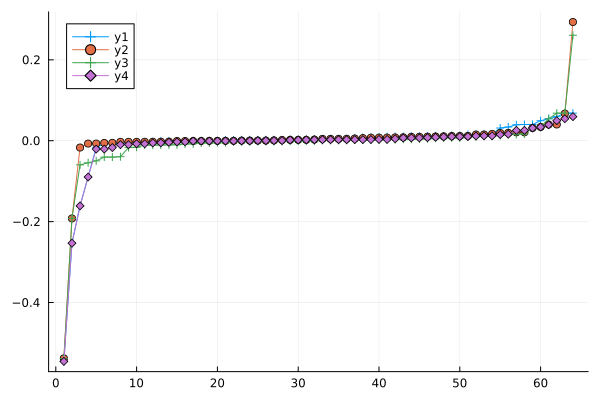

In [49]:
plot(real(vals1), markershape=:auto)
plot!(real(vals2), markershape=:auto)
plot!(real(vals1_G), markershape=:auto)
plot!(real(vals2_G), markershape=:auto)

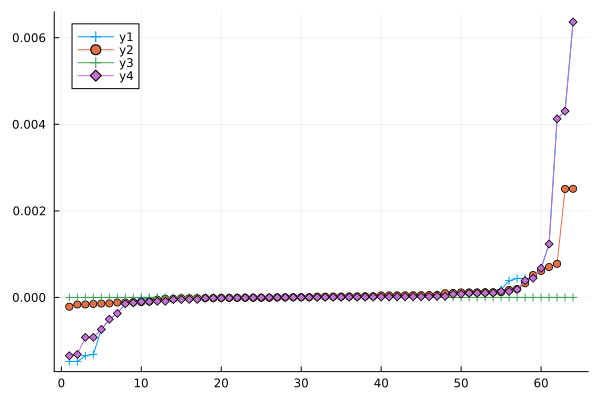

In [51]:
vals1,vecs1 = eigen(Γs_ladder1, sortby=imag)
vals2,vecs2 = eigen(Γs_ladder2, sortby=imag)

vals1_G,vecs1_G = eigen(Γs_ladder1_G, sortby=imag)
vals2_G,vecs2_G = eigen(Γs_ladder2_G, sortby=imag);

plot(imag(vals1), markershape=:auto)
plot!(imag(vals2), markershape=:auto)
plot!(imag(vals1_G), markershape=:auto)
plot!(imag(vals2_G), markershape=:auto)

In [154]:
Γs_ladder2b = Array{ComplexF64, 2}(undef, length(k_vecs)*length(νnGrid), length(k_vecs)*length(νnGrid));
νlen = length(νnGrid)
klen = length(k_vecs)
for (νi,νn) in enumerate(νnGrid)
  for (νpi,νpn) in enumerate(νnGrid)
        slice = klen*(νi-1)+1:klen*(νi),klen*(νpi-1)+1:klen*(νpi)
        #println("νi = $νi / νpi = $νpi / ",slice)
        Γs_ladder2b[slice...] = Γs_ladder2[:,νi,:,νpi]
  end
end

In [155]:
Γs_ladder4_rs = (real(Γs_ladder4) .+ real(Γs_ladder4)') ./ 2 #Matrix(Hermitian(Γs_ladder1));
Γs_ladder3_rs = (real(Γs_ladder3) .+ real(Γs_ladder3)') ./ 2 #Matrix(Hermitian(Γs_ladder1));

println("Symmetrization error (3): ", round(maximum(abs.(Γs_ladder3_rs .- Γs_ladder3)), digits=2))
println("Symmetrization error (4): ", round(maximum(abs.(Γs_ladder4_rs .- Γs_ladder4)), digits=2))

println("Largest imaginary part test3: ", maximum(abs.(imag(Γs_ladder3))))
println("Largest imaginary part test4: ", maximum(abs.(imag(Γs_ladder4))))
println("Difference between 3 and 2b: ", maximum(abs.(Γs_ladder3 .- Γs_ladder2b)))

Symmetrization error (3): 0.01
Symmetrization error (4): 0.01
Largest imaginary part test3: 1.6179109478853424e-8
Largest imaginary part test4: 1.6338563311794795e-8
Difference between 3 and 2b: 1.3966705952318859e-12


Maximum Imaginary Entry of 3: 1.6179109478853424e-8 // 4: 1.6338563311794795e-8


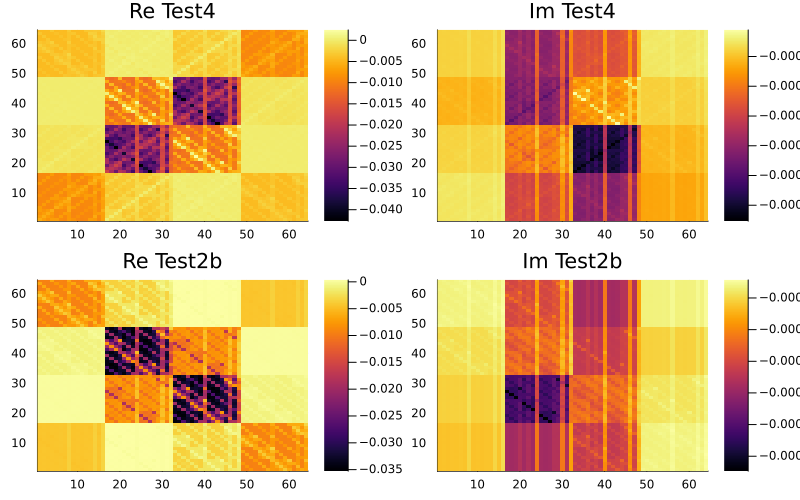

In [156]:
println("Maximum Imaginary Entry of 3: ", maximum(abs.(imag(Γs_ladder3))), " // 4: ", maximum(abs.(imag(Γs_ladder4))))
p1 = heatmap(real(Γs_ladder4), title="Re Test4")
p2 = heatmap(imag(Γs_ladder4), title="Im Test4")
p3 = heatmap(real(Γs_ladder2b), title="Re Test2b")
p4 = heatmap(imag(Γs_ladder2b), title="Im Test2b")

plot(p1, p2, p3, p4, size=(800,500))

In [157]:
using LinearAlgebra
@time ev3,vv3 = eigen(real(Γs_ladder3), sortby=x->real(x))#Γs_ladder3)
@time ev4,vv4 = eigen(real(Γs_ladder4), sortby=x->real(x));#Γs_ladder4)
#@time ev4_2,vv4_2 = eigen(real.(Γs_ladder4)); #Γs_ladder4));

  0.372114 seconds (349.48 k allocations: 22.916 MiB, 97.94% compilation time)
  0.332829 seconds (349.49 k allocations: 22.922 MiB, 99.28% compilation time)


In [158]:
@time ev3_rs,vv3_rs = eigen(Γs_ladder3_rs, sortby=x->real(x))#Γs_ladder3)
@time ev4_rs,vv4_rs = eigen(Γs_ladder4_rs, sortby=x->real(x));

  0.335411 seconds (349.49 k allocations: 22.958 MiB, 99.15% compilation time)
  0.341651 seconds (349.47 k allocations: 22.866 MiB, 99.11% compilation time)


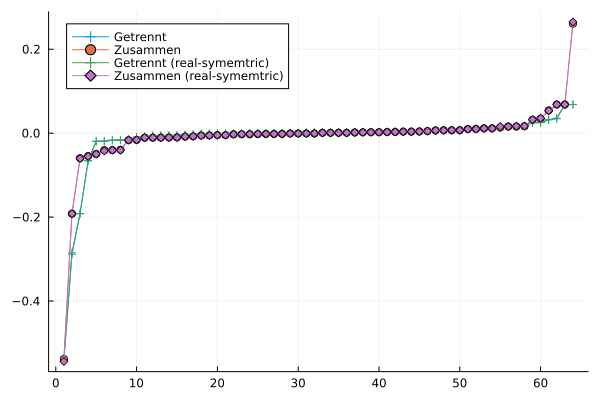

In [159]:
plot(sort(real(ev4)), markershape=:auto, label="Getrennt")
plot!(sort(real(ev3)), markershape=:auto, label="Zusammen")
plot!(sort(real(ev4_rs)), markershape=:auto, label="Getrennt (real-symemtric)")
plot!(sort(real(ev3_rs)), markershape=:auto, label="Zusammen (real-symemtric)")

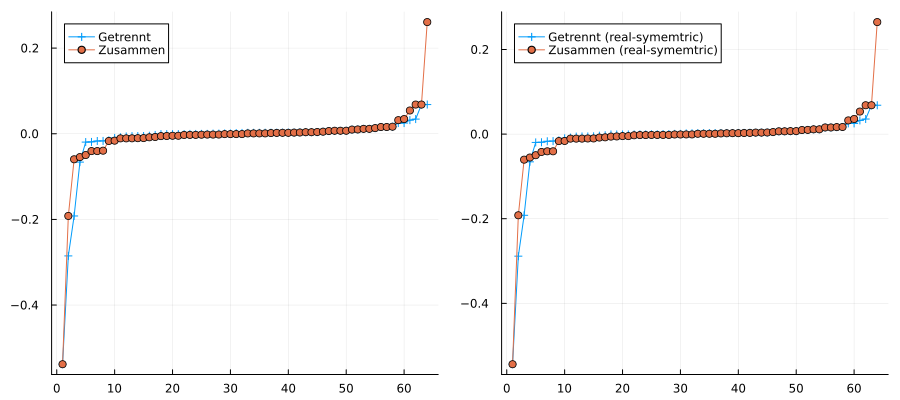

In [160]:
p1 = plot(sort(real(ev4)), markershape=:auto, label="Getrennt")
plot!(sort(real(ev3)), markershape=:auto, label="Zusammen")
p2 = plot(sort(real(ev4_rs)), markershape=:auto, label="Getrennt (real-symemtric)")
plot!(sort(real(ev3_rs)), markershape=:auto, label="Zusammen (real-symemtric)")
plot(p1, p2, size=(900,400))

In [161]:
maximum(abs.(imag(ev4)))

0.0

In [162]:
#ii1_2r = sortperm(real.(ev1_2))
ii3r = sortperm(real.(ev3))
ii4r = sortperm(real.(ev4))
ii4_2r = sortperm(real.(ev4_2))
p1 = plot(real(ev3)[ii3r], markershape=:auto, label="Real Test1",markersize=12)
plot!(real(ev4)[ii4r], markershape=:auto, label="Real Test4",markersize=14)
plot!(real(ev4_2)[ii4_2r], markershape=:auto, label="Real Test4_2")

p2 = plot(real(ev3)[ii3r] .- real(ev4)[ii4r], markershape=:auto, label=" Real Test3 -  Test4")
plot!( real(ev4)[ii4r] .- real(ev4_2)[ii4_2r], markershape=:auto, label=" Real Test4 -  Test4b")
plot(p1, p2, size=(800,400))

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 64 and 16

In [163]:
ii1i = sortperm(imag.(ev1))
#ii1_2i = sortperm(imag.(ev1_2))
ii3i = sortperm(imag.(ev3))
ii4i = sortperm(imag.(ev4))
ii4_2i = sortperm(imag.(ev4_2))
plot(imag(ev1)[ii1i], markershape=:auto, label="Imag Test1",markersize=12)
#plot!(imag(ev1_2)[ii1_2i], markershape=:auto, label="Real Test1_2",markersize=12)
#plot!(imag(ev3)[ii3i], markershape=:auto, label="Imag Test3", markersize=8)
plot!(imag(ev4)[ii4i], markershape=:auto, label="Imag Test4", markersize=14)
plot!(imag(ev4_2)[ii4_2i], markershape=:auto, label="Imag Test4_2")

LoadError: UndefVarError: `ev1` not defined

In [164]:
using Arpack

@time λ3, ϕ3, nconv2, niter2, nmult2, resid2 = eigs(Γs_ladder3; nev=1, which=:LR, tol=1e-18);
@time λ3b, ϕ3b, nconv2, niter2, nmult2, resid2 = eigs(real(Γs_ladder3); nev=1, which=:LR, tol=1e-18);#6392.743357290174 + 415.3295064808915im
@time λ4, ϕ4, nconv3, niter3, nmult3, resid3 = eigs(Γs_ladder4; nev=1, which=:LR, tol=1e-18);
@time λ4b, ϕ4b, nconv3, niter3, nmult3, resid3 = eigs(real(Γs_ladder4); nev=1, which=:LR, tol=1e-18);
println("Largest (real-part) eigenvalue 3/3b\n$λ3\n$λ3b\n\n4/4b\n$λ4\n$λ4b")

  0.000659 seconds (225 allocations: 54.328 KiB)
  0.000321 seconds (234 allocations: 68.922 KiB)
  0.001121 seconds (376 allocations: 58.766 KiB)
  0.000758 seconds (551 allocations: 78.734 KiB)
Largest (real-part) eigenvalue 3/3b
ComplexF64[0.2607462988337682 - 6.702394448971287e-8im]
ComplexF64[0.2607462988337706 + 0.0im]

4/4b
ComplexF64[0.0681388579490408 - 2.6678575481987724e-9im]
ComplexF64[0.06813885794904116 + 0.0im]


In [165]:
using Arpack

@time λ3, ϕ3, nconv2, niter2, nmult2, resid2 = eigs(Γs_ladder3; nev=1, which=:LR, tol=1e-18);
@time λ3b, ϕ3b, nconv2, niter2, nmult2, resid2 = eigs(real(Γs_ladder3); nev=1, which=:LR, tol=1e-18);#6392.743357290174 + 415.3295064808915im
@time λ4, ϕ4, nconv3, niter3, nmult3, resid3 = eigs(Γs_ladder4; nev=1, which=:LR, tol=1e-18);
@time λ4b, ϕ4b, nconv3, niter3, nmult3, resid3 = eigs(real(Γs_ladder4); nev=1, which=:LR, tol=1e-18);

  0.000546 seconds (216 allocations: 53.766 KiB)
  0.000486 seconds (311 allocations: 71.234 KiB)
  0.001113 seconds (376 allocations: 58.766 KiB)
  0.000653 seconds (471 allocations: 76.234 KiB)


In [166]:
println("Largest (real-part) eigenvalue 3/3b\n$λ3\n$λ3b\n\n4/4b\n$λ4\n$λ4b")

Largest (real-part) eigenvalue 3/3b
ComplexF64[0.2607462988337677 - 6.702394449889441e-8im]
ComplexF64[0.26074629883377043 + 0.0im]

4/4b
ComplexF64[0.06813885794904082 - 2.667857531082139e-9im]
ComplexF64[0.0681388579490414 + 0.0im]


In [167]:
@time λ3, ϕ3, nconv2, niter2, nmult2, resid2 = eigs(Γs_ladder3; nev=1, which=:SR, tol=1e-18);
@time λ3b, ϕ3b, nconv2, niter2, nmult2, resid2 = eigs(real(Γs_ladder3); nev=1, which=:LR, tol=1e-18);#6392.743357290174 + 415.3295064808915im
@time λ4, ϕ4, nconv3, niter3, nmult3, resid3 = eigs(Γs_ladder4; nev=1, which=:SR, tol=1e-18);
@time λ4b, ϕ4b, nconv3, niter3, nmult3, resid3 = eigs(real(Γs_ladder4); nev=1, which=:LR, tol=1e-18);
println("Smallest (real-part) eigenvalue 3/3b\n$λ3\n$λ3b\n\n4/4b\n$λ4\n$λ4b")

  0.000566 seconds (219 allocations: 53.953 KiB)
  0.000400 seconds (231 allocations: 68.734 KiB)
  0.000819 seconds (216 allocations: 53.766 KiB)
  0.000838 seconds (391 allocations: 73.734 KiB)
Smallest (real-part) eigenvalue 3/3b
ComplexF64[-0.538141695138707 - 2.5956160696294144e-7im]
ComplexF64[0.26074629883377054 + 0.0im]

4/4b
ComplexF64[-0.5381416951387111 - 2.595616069737714e-7im]
ComplexF64[0.06813885794904145 + 0.0im]


In [168]:
println("matrix 2 with residual norm of ", norm(resid2), " after $niter2 iterations and $nmult2 multiplications")
println("matrix 3 with residual norm of ", norm(resid3), " after $niter3 iterations and $nmult3 multiplications")

matrix 2 with residual norm of 0.006733675923660956 after 1 iterations and 20 multiplications
matrix 3 with residual norm of 0.004434798167879566 after 3 iterations and 40 multiplications


In [169]:
using LinearAlgebra
#@time ev2,vv2 = eigen(Γs_ladder2)
@time ev3,vv3 = eigen(Γs_ladder5)

LoadError: UndefVarError: `Γs_ladder5` not defined

In [170]:
ii = sortperm(real(ev2))
vv2[ii,ii]

LoadError: UndefVarError: `ev2` not defined

In [171]:
ii = sortperm(real(ev3))
vv3[ii,ii]

64×64 Matrix{Float64}:
 -0.017648   0.176016  -0.0115207    1.73811e-16  …  -0.0384678    -0.0362297
 -0.0178629  0.176489   0.0179002   -0.0302841       -0.0193621    -0.0367013
 -0.017648   0.176016  -0.0115207   -2.341e-18        3.17179e-16  -0.0362297
 -0.0181929  0.177077  -0.0192408    0.00664527      -0.0191969    -0.0373825
 -0.0178629  0.176489   0.0179002    0.0302841       -0.0193621    -0.0367013
 -0.0180696  0.176629   0.0488871    2.51915e-16  …   3.64293e-16  -0.0372331
 -0.0178629  0.176489   0.0179002    0.0302841        0.0193621    -0.0367013
 -0.0183394  0.177213   0.00948148   0.0386036        9.03648e-17  -0.037881
 -0.017648   0.176016  -0.0115207   -8.02257e-17      2.15549e-16  -0.0362297
 -0.0178629  0.176489   0.0179002   -0.0302841        0.0193621    -0.0367013
 -0.017648   0.176016  -0.0115207    4.89335e-17  …   0.0384678    -0.0362297
 -0.0181929  0.177077  -0.0192408    0.00664527       0.0191969    -0.0373825
 -0.0181929  0.177077  -0.0192408   -0.006

In [172]:
r_ev = sort(real(ev2))
println("largest eigen value $(r_ev[end]), smallest eigen value $(r_ev[1])")
plot(sort(real(ev2)),markershape=:auto)

LoadError: UndefVarError: `ev2` not defined

In [173]:
plot(sort(imag(ev2)),markershape=:auto)

LoadError: UndefVarError: `ev2` not defined

In [174]:
plot(sort(abs.(ev2)),markershape=:auto)

LoadError: UndefVarError: `ev2` not defined

### Internal Test

In [175]:
cfg = "/home/julisn/Codes/lDGA_pp_test/tp1_50_s1_U2.0_b5.0_mu1.0/config.toml"
empty!(ARGS)
push!(ARGS, cfg)
include("/home/julisn/Codes/LadderDGA.jl/scripts/linEliashberg.jl")

activating: /home/julisn/Codes/LadderDGA.jl/scripts/..
[ Info: Reading Inputs...
[ Info: Setting up calculation for kGrid 2Dsc-0.25-0.2-0.1 of size 4


  Activating project at `~/Codes/LadderDGA.jl`


WARNING!!! k-grid sampling must contain zero-vector in order for convolutions to work!
DBG: NOT using diagonal terms in λ₀
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_m(1:101) = 0.4074, χLoc_d(1:101) = 0.0926
└ sum χupup check (plain ?≈? tail sub ?≈? imp_dens ?≈? n/2 (1-n/2)): 0.24837998506431677 ?=? 0.2499966841631163 ?≈? 0.2499966841631163 ≟ 0.24999268986197437"
output file location: /home/julisn/Codes/lDGA_pp_test/tp1_50_s1_U2.0_b5.0_mu1.0/test_res_ldga_LinEliashberg_NK4_Nw100.jld2
[ Info: m channel: |∑χ(q=0,ω≠0)| = 0.014475082287 ≟ 0
[ Info: d channel: |∑χ(q=0,ω≠0)| = 0.021694089905 ≟ 0
DBG: NOT using diagonal terms in λ₀
DBG: λm=-0.0516, λd=0.8909, μ=0.9835, n=1.0054 // EPot_p1: 0.1912 , p2: 0.1912 :: 0.25 // 0.25
DBG: λm=-0.0504, λd=0.7739, μ=0.9802, n=1.0054 // EPot_p1: 0.1925 , p2: 0.1925 :: 0.25 // 0.25
DBG: λm=-0.0505, λd=0.7884, μ=0.9799, n=1.0054 // EPot_p1: 0.1923 , p2: 0.1923 :: 0.25 // 0.25
DBG: λm=-0.0505, λd=0.7879, μ=0.9

(0.0806125257897165 + 1.7552571832083476e-5im, 0.08061252578971624 + 1.755257183207024e-5im, -0.6001490873776016 + 0.0003465977640897781im, -0.6001490873776016 + 0.0003465977640897129im)

In [176]:
real.(λ_list)

([0.06804065287460692], [0.06804065287460727], [-0.5395162609656359], [-0.5395162609656313])

In [177]:
real.(λ_m_list)

([0.07311726131685088], [0.07311726131685115], [-0.5760052137894085], [-0.5760052137894052])

In [178]:
real.(λ_dm_list)

([0.07411120558580106], [0.07411120558580095], [-0.5842133524392867], [-0.5842133524392878])

In [179]:
real.(λ_dm_sc_gLoc_list)

([0.07426362912856263], [0.07426362912856269], [-0.5854663938156743], [-0.5854663938156728])

In [180]:
real.(λ_dm_sc_list)

([0.0806125257897165], [0.08061252578971624], [-0.6001490873776016], [-0.6001490873776016])

In [181]:
res_dm_sc.G_ladder

6×401 OffsetArray(::Matrix{ComplexF64}, 1:6, -200:200) with eltype ComplexF64 with indices 1:6×-200:200:
  9.13983e-6+0.00398876im  …   9.04889e-6-0.00396887im
  7.54881e-6+0.00398877im       7.4737e-6-0.00396887im
 -6.77049e-6+0.00398877im     -6.70312e-6-0.00396888im
  1.86857e-5+0.00398869im      1.84998e-5-0.0039688im
 -8.36151e-6+0.00398876im     -8.27831e-6-0.00396887im
 -2.26802e-5+0.00398865im  …  -2.24545e-5-0.00396876im

## Matrix Free Tests

In [182]:
using LinearAlgebra, Arpack, LinearMaps
using BenchmarkTools

N = 30
A = convert.(Float64, reshape(1:(N*N),N,N))
f(i,j) = 1.0*j .+ (N-1) .* (j .- 1) .+ (i .- 1)
f2(v) = map(i -> sum(v .* f(i,1:N)), 1:N)

A_mf = LinearMap{Float64}(f2,N)
vals1,vecs1 = eigs(A, which=:LM, nev=2, tol=1e-12, maxiter=500)
vals2,vecs2 = eigs(A_mf, which=:LM, nev=2, tol=1e-12, maxiter=500)
println("CHECK: ", all(isapprox.(vals1,vals2))))
# execute once for precompilation
@benchmark vals1,vecs1 = eigs($A, which=:LM, nev=2, tol=1e-12, maxiter=500)
@benchmark vals2,vecs2 = eigs($A_mf, which=:LM, nev=2, tol=1e-12, maxiter=500)

LoadError: ArgumentError: Package LinearMaps not found in current path.
- Run `import Pkg; Pkg.add("LinearMaps")` to install the LinearMaps package.